In [1]:
from pymongo import MongoClient
import certifi
import os
from dotenv import load_dotenv
from utils.translation import translate_text
from utils.courses import find_courses_by_name, retrieve_lessons_text, get_google_translations_from_txt, encode_course_by_lesson ,pca_encodings_by_lesson
import pandas as pd
from functools import partial, reduce
from random import randint
from utils.courses import keys_to_tuple
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle as pkl

c:\Users\Usuario\Desktop\monitoria\analisis_traducciones\monenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
#Load env variables
load_dotenv()
MONGO_URI = os.environ["MONGO_DB_URI"]
PATH = os.environ["DIR_PATH"]

In [ ]:
#Load the gcf data from the MongoDB db
ca = certifi.where()
cluster = MongoClient(host=MONGO_URI, tlsCAFile=ca)
db = cluster["gcfglobal"]
collection_lessons = db["lesson"]
collection_tutorials = db['tutorial']

# Build a dictionary with all the courses lessons

- Additionally, we generate colors for each course

In [ ]:
paths = [
    ('excel-2016',),  
    ('powerpoint-2019',), 
    ('whatsapp-business',), 
    ('tudo-sobre-o-windows-10', 'como-usar-windows-10'),
    ('google-sala-de-aula-para-alunos', 'google-classroom-para-estudiantes'),
    ('numeros-fracionarios', 'fraccionarios'),
    ('usando-a-matematica', 'aplicaciones-de-la-matematica'),
]

In [ ]:
f = partial(find_courses_by_name, collection_tutorials)
g = (lambda x: retrieve_lessons_text(collection_lessons, f(x)))

In [ ]:
complete_lessons = reduce(lambda x,y: x | y, map(g,paths), dict()) 

Found 2 tutorials for course excel-2016 

Found 2 tutorials for course powerpoint-2019 

Found 2 tutorials for course whatsapp-business 

Found 1 tutorials for course tudo-sobre-o-windows-10 

Found 1 tutorials for course como-usar-windows-10 

Found 1 tutorials for course google-sala-de-aula-para-alunos 

Found 1 tutorials for course google-classroom-para-estudiantes 

Found 1 tutorials for course numeros-fracionarios 

Found 1 tutorials for course fraccionarios 

Found 1 tutorials for course usando-a-matematica 

Found 1 tutorials for course aplicaciones-de-la-matematica 



In [ ]:
courses = list(complete_lessons.keys())

In [ ]:
def listdirs(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Get encodings (lesson level) with Google Translate Text Included

In [ ]:
h = partial(get_google_translations_from_txt, 'C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate')
google_translations = list(zip(courses,(map(lambda x: h(x,complete_lessons), courses))))

In [ ]:
complete_lessons_encodings = reduce(lambda x, y: x | y, map(lambda x: encode_course_by_lesson(complete_lessons, x[0],'multi-qa-distilbert-cos-v1',x[1]),google_translations), dict())

# PCA for each of the encodings

In [ ]:
total_encodings = np.concatenate(list(map(lambda x: complete_lessons_encodings[x[0]][x[1]], keys_to_tuple(complete_lessons_encodings))))

In [ ]:
pca = PCA(n_components = 2)
pca2 = PCA(n_components = 3)
pca.fit(total_encodings)
pca2.fit(total_encodings)
tsne = TSNE(2,perplexity=2)
tsne.fit(total_encodings)

TSNE(perplexity=2)

In [ ]:
pca_vectors = list(map(lambda x: ((x[0],x[1]),pca.transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))
pca2_vectors = list(map(lambda x: ((x[0],x[1]),pca2.transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))
tsne_vectors = list(map(lambda x: ((x[0],x[1]),tsne.fit_transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))

In [ ]:
with open('pca_vectors.pickle', 'wb') as handle:
    pkl.dump(pca_vectors, handle, protocol=pkl.HIGHEST_PROTOCOL)

# Gráfica por Curso (nivel de lesson)

In [ ]:
from colour import Color

In [ ]:
import random
def generate_colors(courses: list,colors=[]):
    if len(colors) == len(courses):
        return colors
    else:
        r = round(random.uniform(0,1),2)
        g = round(random.uniform(0,1),2)
        b = round(random.uniform(0,1),2)
        return generate_colors(courses, [*colors, Color(rgb=(r,g,b)).get_hex_l()])

In [ ]:
print(courses)

['excel-2016', 'powerpoint-2019', 'whatsapp-business', 'tudo-sobre-o-windows-10', 'google-sala-de-aula-para-alunos', 'numeros-fracionarios', 'usando-a-matematica']


In [ ]:
colors_for_course = list(zip(courses,generate_colors(courses)))
colors_for_course2 = list(zip(courses,generate_colors(courses)))

In [29]:
colors_dict = dict(colors_for_course)

In [30]:
colors_dicts2 = dict(colors_for_course2)

In [31]:
print(colors_dict)

{'excel-2016': '#38915c', 'powerpoint-2019': '#389ecc', 'whatsapp-business': '#7afffc', 'tudo-sobre-o-windows-10': '#d69196', 'google-sala-de-aula-para-alunos': '#b8e505', 'numeros-fracionarios': '#590da1', 'usando-a-matematica': '#6136ed'}


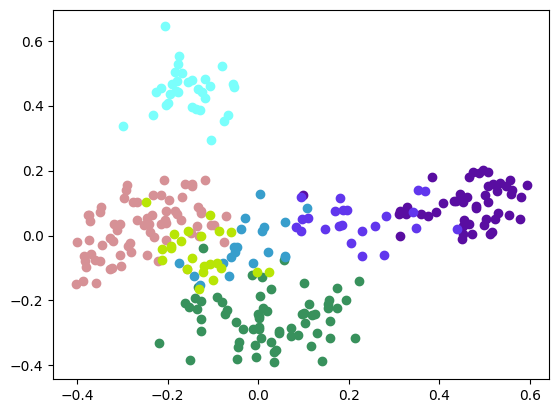

In [32]:
import matplotlib.pyplot as plt
i = 0
for (course_name, language), vectors in pca_vectors:
    if language == 'google':
        continue
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    plt.scatter(x, y, color=colors_dict[course_name])


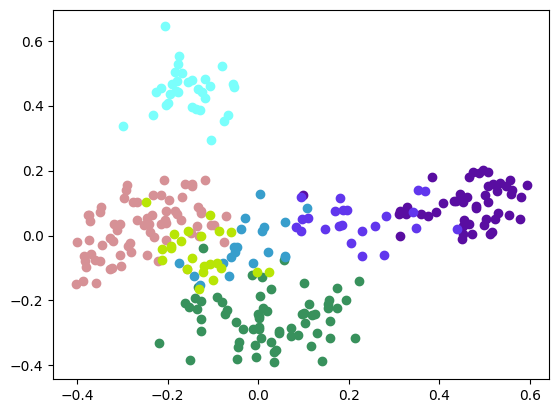

In [33]:
i = 0
for (course_name, language), vectors in pca2_vectors:
    if language == 'google':
        continue
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    z = list(map(lambda x: x[2], vectors))
    plt.scatter(x, y, color=colors_dict[course_name])

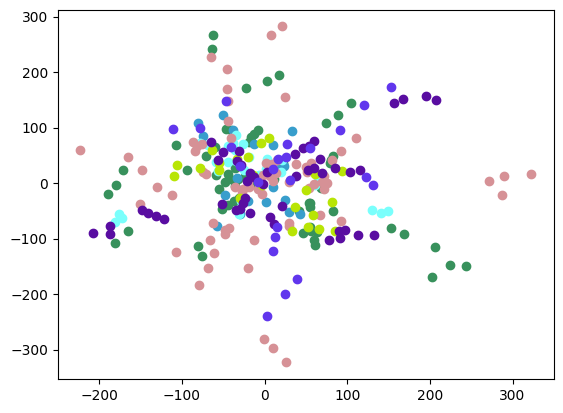

In [34]:
import matplotlib.pyplot as plt
i = 0
for (course_name, language), vectors in tsne_vectors:
    if language == 'google':
        continue
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    plt.scatter(x, y, color=colors_dict[course_name])

# Graficar por lenguaje

In [35]:
language_color_dict = {'es': '#FF0000', 'pt': '#0000FF', 'google': '#00FF00'}
#Verde: Google
#Rojo: Español
#Azul: Portugues

In [36]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

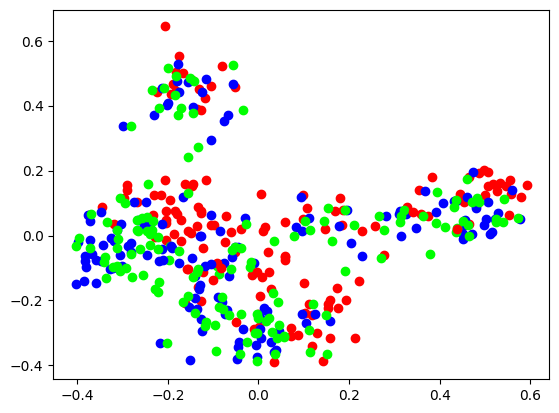

In [40]:
for (course_name, language), vectors in pca_vectors:
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    plt.scatter(x, y, color=language_color_dict[language])

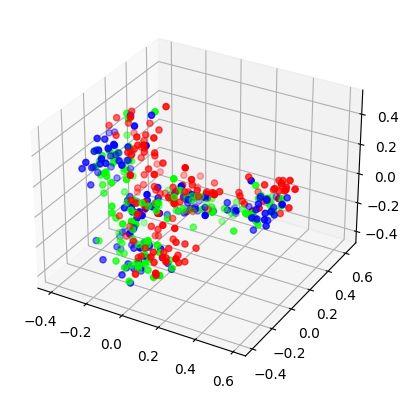

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for (course_name, language), vectors in pca2_vectors:
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    z = list(map(lambda x: x[2], vectors))
    ax.scatter(x, y,z, color=language_color_dict[language])


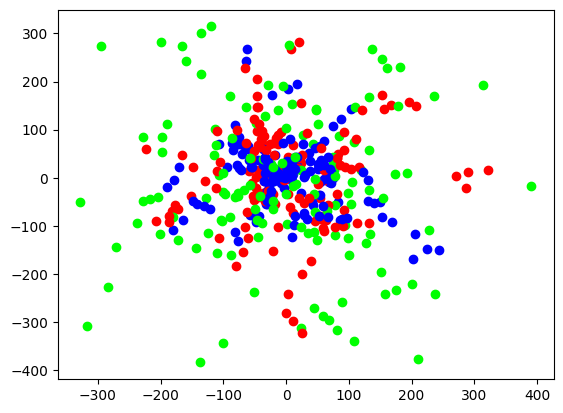

In [42]:
for (course_name, language), vectors in tsne_vectors:
    x = list(map(lambda x: x[0], vectors))
    y = list(map(lambda x: x[1], vectors))
    xs = []
    ys = []
    for i in range(len(x)):
        if x[i]>-500 and x[i] <500 and y[i]>-500 and y[i] <500:
            xs.append(x[i])
            ys.append(y[i])
    plt.scatter(xs, ys, color=language_color_dict[language])